#Notes on Filtering and Square-law detector

This notebook has a few examples and generates some graphs used in the thesis in Chapter 4

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import numpy as np
import scipy.io as sio
import matplotlib.image as mpimg
from scipy import signal
import savitzky_golay

##Square-law detector
A square-law detector can look at a noisy signal with a mean value of zero, and read the peak values to get a total power of that signal.  Here we will generate a noisy signal (white noise) signal and then look at the peak values and trace them.  Then we will build a square-law detector which is x^2 to detect the total power and filter it with a low pass filter to smooth the signal out.  Finally we will compare the various graphs created.

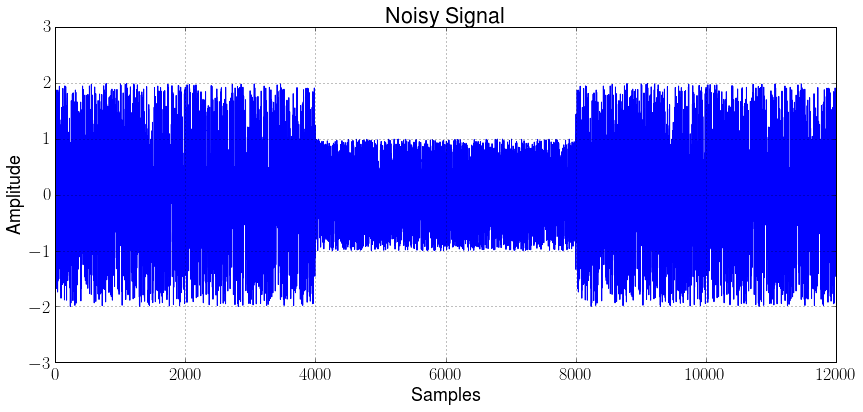

In [3]:
#Generate a noisy signal
NOISE_AMPLITUDE = 4.0
PERIOD = 200
PRESENCE_PROBABILITY = .4
# size of sample
S_O_S = 4000

signal = np.where(np.arange(4000) % PERIOD > PERIOD / 2, 0.5, -0.5)
noise = np.random.uniform(
    low=-0.5*NOISE_AMPLITUDE, 
    high=0.5*NOISE_AMPLITUDE, 
    size=S_O_S
)

#The noisy signal with a higher amplitude
noise = np.where(
    np.random.uniform(size=len(noise)) < PRESENCE_PROBABILITY, 
    signal, noise
)
#The noisy signal with a lower amplitude
noise1 = np.random.uniform(
    low=-0.25*NOISE_AMPLITUDE, 
    high=0.25*NOISE_AMPLITUDE, 
    size=S_O_S
)

#Now we combine the two signals 
noisy1 = np.append(noise,noise1);
noisy = np.append(noisy1,noise);

matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})


fig = plt.figure(figsize=(14,6), dpi=300)
plt.plot( noisy,'b-', label="signal mixed in random noise")

xlabel('Samples')
ylabel('Amplitude')
title('Noisy Signal')
axis([0, 12000, -3, 3])
grid(True)

fig.savefig("noisy_sig.pdf", dpi=300)
fig.savefig("noisy_sig.png", dpi=300)

Now we let's draw a line on where the peak values should be.  Since we defined this in the noise generator we expect the absolute value of the peaks at 2 from 0 to 4000 samples, 1 for 4000 to 8000 samples and back to 2 from 8000 to 12000 samples.  

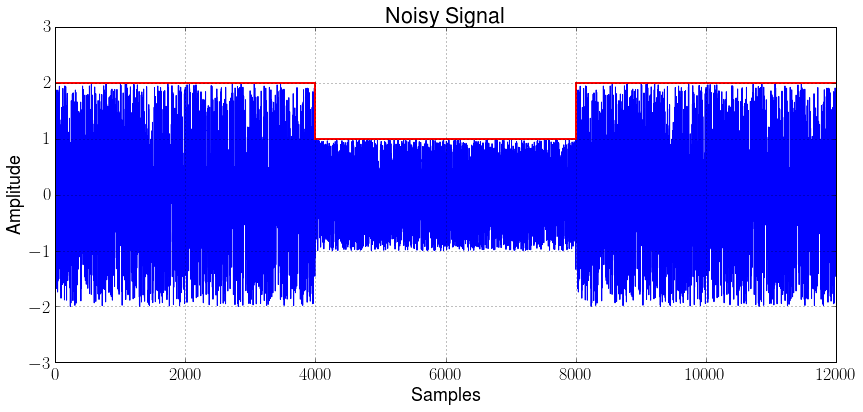

In [4]:
matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})


fig = plt.figure(figsize=(14,6), dpi=300)
plt.plot( noisy,'b-', label="signal mixed in random noise")
plt.plot([0, 4000], [2, 2], color='red', linestyle='-', linewidth=2)
plt.plot([4000, 4000], [2, 1], color='red', linestyle='-', linewidth=2)
plt.plot([4000, 8000], [1, 1], color='red', linestyle='-', linewidth=2)
plt.plot([8000, 8000], [1, 2], color='red', linestyle='-', linewidth=2)
plt.plot([8000, 12000], [2, 2], color='red', linestyle='-', linewidth=2)

xlabel('Samples')
ylabel('Amplitude')
title('Noisy Signal')
axis([0, 12000, -3, 3])
grid(True)

fig.savefig("noisy_sig_line.pdf", dpi=300)
fig.savefig("noisy_sig_line.png", dpi=300)

Now we will implement the square law detector and filter this using a low pass filter.  Let's begin by building the low pass filter and looking at the response of that filter.

1450.5


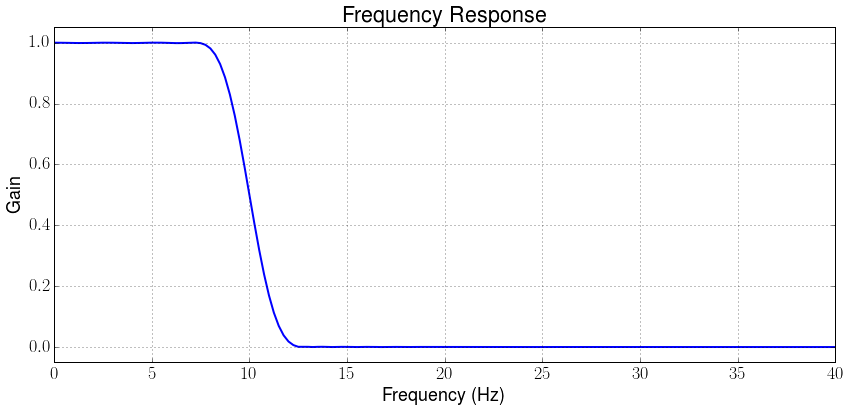

In [5]:
fig = plt.figure(figsize=(14,6), dpi=300)

from scipy.signal import kaiserord, lfilter, firwin, freqz

#First define our filter parameters
cutoff = 10.0
fs = 4000
nsamples = 12000
#t = arange(nsamples) / fs

nyq_rate = fs / 2.0
# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate 

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
 
# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff/nyq_rate, window=('kaiser', beta))

# The phase delay of the filtered signal.
delay = (0.5 * (N-1) / fs)*fs
print delay

#Plot the frequency response
w, h = freqz(taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
xlim(0,40)
grid(True)


Now we use our square-law detector and apply the filter we created above to filter the signal.  Then graph this on our original signal.

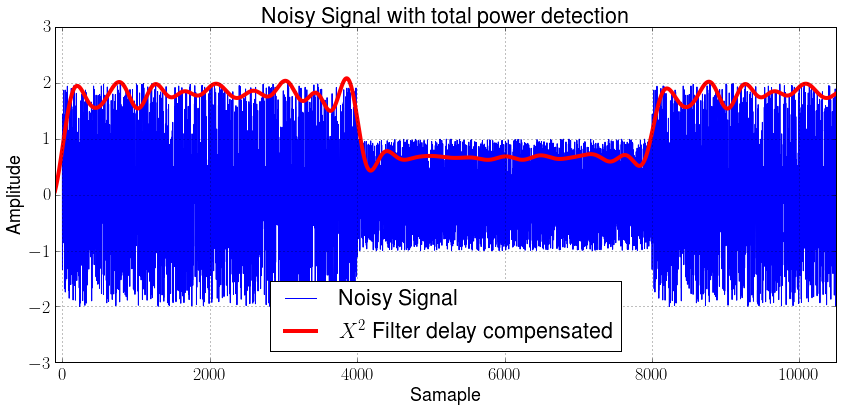

In [6]:
fig = plt.figure(figsize=(14,6), dpi=300)

#def butter_lowpass(cutoff, fs, order=5):
#   nyq = 0.5 * fs
#  normal_cutoff = cutoff / nyq
#    b, a = butter(order, normal_cutoff, btype='low', analog=False)
#    return b, a

#def butter_lowpass_filter(data, cutoff, fs, order=5):
#    b, a = butter_lowpass(cutoff, fs, order=order)
#    y = lfilter(b, a, data)
#    return y
#Simulating a square-law detector (X^2)
square = noisy**2
# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, .5, square)

t = np.linspace(0,12000,12000)
# Plot the original signal.
plt.plot(t,noisy,label='Noisy Signal')
# Plot the filtered signal, shifted to compensate for the phase delay.
#plt.plot(t,filtered_x, 'g-',label='Filtered X^2 signal',linewidth=4)
plt.plot(t-delay,filtered_x,'r-',label='$X^2$ Filter delay compensated',linewidth=4)
#y = butter_lowpass_filter(square, cutoff, fs, order)
#plt.plot(noisy)
#plt.plot(y*2,'r')
xlabel('Samaple')
ylabel('Amplitude')
title('Noisy Signal with total power detection')
axis([-100, 10500, -3, 3])
grid(True)
plt.legend(loc='lower center')
fig.savefig("TPR.pdf", dpi=300)
fig.savefig("TPR.png", dpi=300)